# Data Loading

In [4]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [14]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
scores = final['Score']

# Split the Data Set into train and test

In [16]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
# =============================================================================================
#supress warnings
warnings.filterwarnings("ignore")
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['Text'].values, scores, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit(X_tr)
X_tr_vector = final_tf_idf.transform(X_tr)
X_cv_vector = final_tf_idf.transform(X_cv)
X_test_vector = final_tf_idf.transform(X_test)



# CV Accuracy

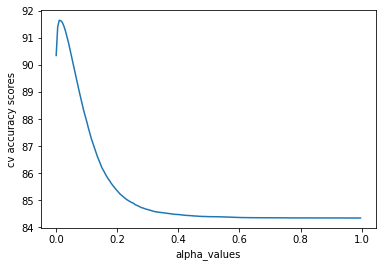

In [17]:
from sklearn.naive_bayes import MultinomialNB
cv_scores = []
alpha_values =[]
i = .001
while i <=1:
    
    clf = MultinomialNB(alpha=i)
    
    clf.fit(X_tr_vector, y_tr)

    # predict the response on the crossvalidation train
    pred = clf.predict(X_cv_vector)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    alpha_values.append(i)
    i +=.005
plt.plot(alpha_values, cv_scores)
plt.xlabel('alpha_values')
plt.ylabel('cv accuracy scores')
plt.show()

# Test Accuarcy

In [18]:
clf = MultinomialNB(alpha=0.006000)
clf.fit(X_tr_vector, y_tr)
pred = clf.predict(X_test_vector)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for alpha = 0.006000 is %f%%' % (acc))


****Test accuracy for alpha = 0.006000 is 91.291693%


# Optimal alpha


The optimal alpha is 0.006000.


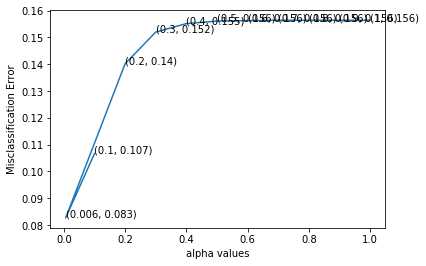

the misclassification error for each alpha value is :  [0.107 0.083 0.14  0.152 0.155 0.156 0.156 0.156 0.156 0.156 0.156]


In [19]:
# creating odd list of alpha for NB
alpha_values = [0.1,0.006,.2,.3,.4,.5,.6,.7,.8,.9,1]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for a in alpha_values:
    clf = MultinomialNB(alpha=a)
    scores = cross_val_score(clf, X_tr_vector, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal alpha is %f.' % optimal_alpha)
# plot misclassification error vs alpha
plt.plot(alpha_values, MSE)

for xy in zip(alpha_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('alpha values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

# Most Important features

In [20]:
def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    print("Important words in negative reviews")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------")
    print("Important words in positive reviews")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat) 
    
clf = MultinomialNB(alpha=optimal_alpha)
clf.fit(X_tr_vector, y_tr)
important_features(tf_idf_vect,clf,10)

Important words in negative reviews
negative 1291.4140246952322 the
negative 848.4659422567983 it
negative 730.0483386775591 and
negative 721.9951043790128 to
negative 656.0796059559023 of
negative 652.7736894624535 br
negative 622.3703730883636 this
negative 619.116390948637 not
negative 594.5216855908126 was
negative 522.8958803912823 is
-----------------------------------------
Important words in positive reviews
positive 5877.660057158646 the
positive 4707.391284643616 and
positive 4642.18663739555 it
positive 3877.295677473296 to
positive 3390.3621874640553 is
positive 3183.6990066874223 br
positive 3165.145227204504 this
positive 3136.3383401294077 of
positive 2733.3236813691515 for
positive 2633.6576029582598 in


# Accuracy,Confusion Matrix,Precision_score,recall_score & f1_score

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
clf = MultinomialNB(alpha=optimal_alpha)
clf.fit(X_tr_vector, y_tr)
pred = clf.predict(X_test_vector)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for optimal alpha is %f%%' % (acc))
print('\n****Confusion matrix**')
c = confusion_matrix(y_test, pred)
print(c)
print('\n****precision score using average=macro**')
print(precision_score(y_test, pred, average='macro'))
print('\n****precision score using average=micro**')
print(precision_score(y_test, pred, average='micro'))
print('\n****precision score using average=weighted**')
print(precision_score(y_test, pred, average='weighted'))
print('\n****precision score using average=None**')
print(precision_score(y_test, pred, average=None))
print('\n****recall score using average=macro**')
print(recall_score(y_test, pred, average='macro'))
print('\n****recall score using average=micro**')
print(recall_score(y_test, pred, average='micro'))
print('\n****recall score using average=weighted**')
print(recall_score(y_test, pred, average='weighted'))
print('\n****recall score using average=None**')
print(recall_score(y_test, pred, average=None))
print('\n****f1 score using average=macro**')
print(f1_score(y_test, pred, average='macro'))
print('\n****f1 score using average=micro**')
print(f1_score(y_test, pred, average='micro'))
print('\n****f1 score using average=weighted**')
print(f1_score(y_test, pred, average='weighted'))
print('\n****f1 score using average=None**')
print(f1_score(y_test, pred, average=None))


****Test accuracy for optimal alpha is 91.291693%

****Confusion matrix**
[[ 8728  8485]
 [ 1029 91010]]

****precision score using average=macro**
0.9046282939668324

****precision score using average=micro**
0.9129169260059312

****precision score using average=weighted**
0.9115395821720254

****precision score using average=None**
[0.89453726 0.91471933]

****recall score using average=macro**
0.7479392876217448

****recall score using average=micro**
0.9129169260059312

****recall score using average=weighted**
0.9129169260059312

****recall score using average=None**
[0.50705862 0.98881996]

****f1 score using average=macro**
0.7987825142548056

****f1 score using average=micro**
0.9129169260059312

****f1 score using average=weighted**
0.9025746133006448

****f1 score using average=None**
[0.64723767 0.95032736]


# TPR,TNR,FPR &FNR

In [22]:
TP = c[0][0]
FP = c[0][1]
FN = c[1][0]
TN = c[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print("TPR:"+str(TPR))
print("TNR:"+str(TNR))
print("FPR:"+str(FPR))
print("FNR:"+str(FNR))
print("Accuracy:"+str(ACC))

TPR:0.8945372553038844
TNR:0.9147193326297804
FPR:0.08528066737021961
FNR:0.1054627446961156
Accuracy:0.9129169260059312


[[ 8728  8485]
 [ 1029 91010]]


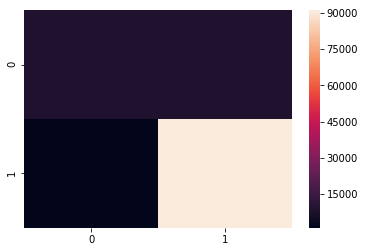

In [23]:
import seaborn as sns
ax = sns.heatmap(c)
print(c)

# Conclusion

In [25]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Model', 'Hyperparameter','Train Error','Test Error']
t.add_row(["MultinomialNB using tfidf vectorizer","0.006000","0.082","0.083"])
t.add_row(["MultinomialNB using BOW vectorizer","1","0.094","0.0908"])
print(t)

+--------------------------------------+----------------+-------------+------------+
|                Model                 | Hyperparameter | Train Error | Test Error |
+--------------------------------------+----------------+-------------+------------+
| MultinomialNB using tfidf vectorizer |    0.006000    |    0.082    |   0.083    |
|  MultinomialNB using BOW vectorizer  |       1        |    0.094    |   0.0908   |
+--------------------------------------+----------------+-------------+------------+
